# ANEXO I: CÓDIGO EN PYTHON Y LOS RESULTADOS DE SU EJECUCIÓN

En este anexo se detallan los procesos de estudio y tratamiento del conjunto de datos inicial, construcción y entrenamiento de dos modelos de predicción de impagos de préstamos bancarios (uno siguiendo utilizando métodos estadísticos tradicionales y otro construido con técnicas de aprendizaje automático), y validación de los resultados obtenidos por dichos modelos.

Para ello, se adjunta un cuaderno de Jupyter Notebook escrito en el lenguaje de programación Python. Este cuaderno intercala secciones de texto con secciones de código seguidas de los resultados obtenidos de su ejecución. 
* Las secciones de texto incluyen títulos y explicaciones sobre el código y los resultados del código. 
* Las secciones de código se ejecutan de arriba a abajo del documento, como indica el orden de los números azules que aparecen a la izquierda de las cajas o bloques de código (por ejemplo, In [12]). Debajo de cada bloque de código, aparece el resultado de la ejecución de dicho bloque, en los casos en los que el código devuelve algún resultado. En las secciones de código también se incluyen comentarios (el texto incluido detrás de un #) para facilitar la lectura del código.

# Carga del conjunto de datos

El conjunto de datos es extraído del siguiente enlace desde Kaggle.com https://www.kaggle.com/code/devraai/credit-analysis-default-prediction/input

In [33]:
# Carga del conjunto de datos
import pandas as pd
datos_prestamos = pd.read_csv('cr_loan2.csv')
display(datos_prestamos.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Análisis del conjunto de datos

A continuación, se analiza el conjunto de datos para tomar decisiones de diseño y tratamiento de la información.

In [34]:
# Dimensiones del conjunto de datos
datos_prestamos.shape

(32581, 12)

In [35]:
# Mostrar el número de valores únicos que contiene cada variable o columna
for column in datos_prestamos.columns:
    print(f"Número de valores únicos en '{column}': {datos_prestamos[column].nunique()}")
    # Si el número de valores únicos es menor que 10, mostrar cada uno de esos valores
    if datos_prestamos[column].nunique() < 10:
        print(f"\tValores únicos en '{column}': {datos_prestamos[column].unique()}\n")

Número de valores únicos en 'person_age': 58
Número de valores únicos en 'person_income': 4295
Número de valores únicos en 'person_home_ownership': 4
	Valores únicos en 'person_home_ownership': ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

Número de valores únicos en 'person_emp_length': 36
Número de valores únicos en 'loan_intent': 6
	Valores únicos en 'loan_intent': ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

Número de valores únicos en 'loan_grade': 7
	Valores únicos en 'loan_grade': ['D' 'B' 'C' 'A' 'E' 'F' 'G']

Número de valores únicos en 'loan_amnt': 753
Número de valores únicos en 'loan_int_rate': 348
Número de valores únicos en 'loan_status': 2
	Valores únicos en 'loan_status': [1 0]

Número de valores únicos en 'loan_percent_income': 77
Número de valores únicos en 'cb_person_default_on_file': 2
	Valores únicos en 'cb_person_default_on_file': ['Y' 'N']

Número de valores únicos en 'cb_person_cred_hist_length': 29


## Análisis y corrección de valores nulos

In [36]:
# Se muestra el número de valores nulos de cada variable (N/A o en blanco)
datos_prestamos.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Hay valores nulos en las variables `person_emp_length` y `loan_int_rate`, es decir, en las variables de "cantidad de años trabajando de la persona solicitante del préstamo" y "tipo de interés del préstamo". 


Al ser ambas variables numéricas, se rellenan los valores nulos con la mediana de cada variable correspondiente, para evitar que el valor se vea afectado por valores extremos.

In [37]:
# Se obtiene la mediana de las variables que presentan valores nulos
person_emp_length_median = datos_prestamos['person_emp_length'].median()
loan_int_rate_median = datos_prestamos['loan_int_rate'].median()

# Se imprimen dichos valores
print(f'Mediana de person_emp_length: {person_emp_length_median}',
      f'\nMediana de loan_int_rate: {loan_int_rate_median}')

# Se rellenan los valores nulos de cada variable con su respectivo valor de la mediana
datos_prestamos['person_emp_length'] = datos_prestamos['person_emp_length'].fillna(person_emp_length_median)
datos_prestamos['loan_int_rate'] = datos_prestamos['loan_int_rate'].fillna(loan_int_rate_median)

Mediana de person_emp_length: 4.0 
Mediana de loan_int_rate: 10.99


## Análisis de observaciones duplicadas

In [38]:
datos_prestamos.duplicated().sum()

np.int64(165)

Hay 165 observaciones que están duplicadas, es decir, en al menos dos filas del conjunto de datos, los valores de las variables son exactamente los mismos. Se consideran dos aspectos:
* 165 observaciones representan un 0,5% sobre el número de observaciones totales (32851), es decir, una cantidad muy baja. Si se eliminaran estas observaciones, muy posiblemente no afectarían al rendimiento del modelo, así como si realmente se tratasen de un error, tampoco tergiversaría los resultados significativamente. 
* El conjunto de datos con el que se está trabajando no tiene un identificador único de contrato ni de prestatario, que correspondería a una "clave primaria" en las bases de datos típicas con las que suelen trabajar los bancos. Por lo tanto, se puede asumir que este conjunto de datos ya ha recibido un tratamiento de duplicados previo, ya que no existe un identificador único que permita en este caso realizar tal análisis.

En base a todo ello, se decide no eliminar estos valores.

## Análisis y corrección de variables numéricas

### Análisis de correlación

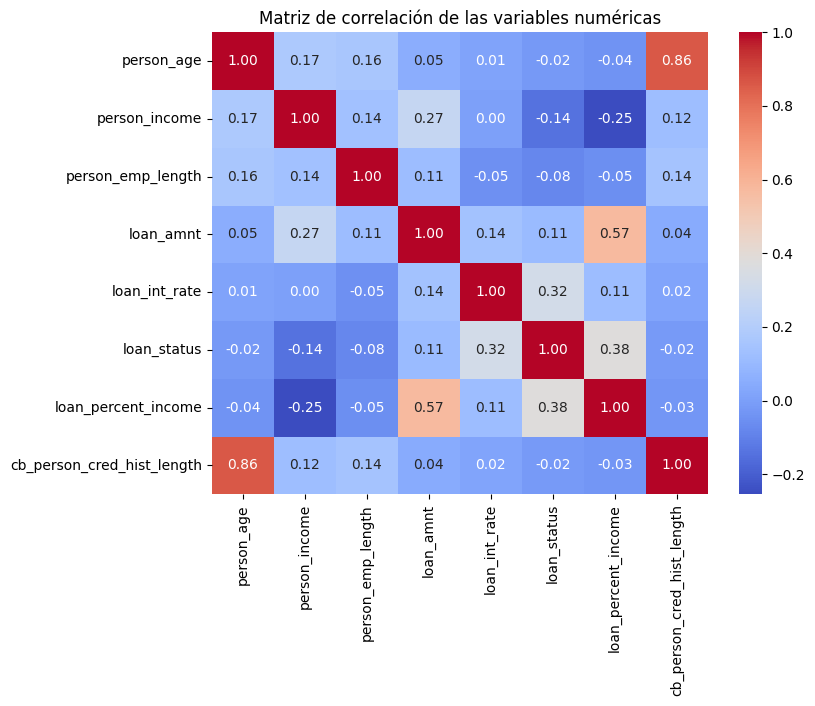

In [6]:
# Se seleccionan las variables numéricas para el análisis de correlación
datos_prestamos_num = datos_prestamos.select_dtypes(include=['number'])

# Se calcula la matriz de correlación entre todas las variables numéricas
correlation = datos_prestamos_num.corr()

# Visualización de la matriz de correlación con un mapa de calor
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de correlación de las variables numéricas')
plt.show()

### Análisis de distribución

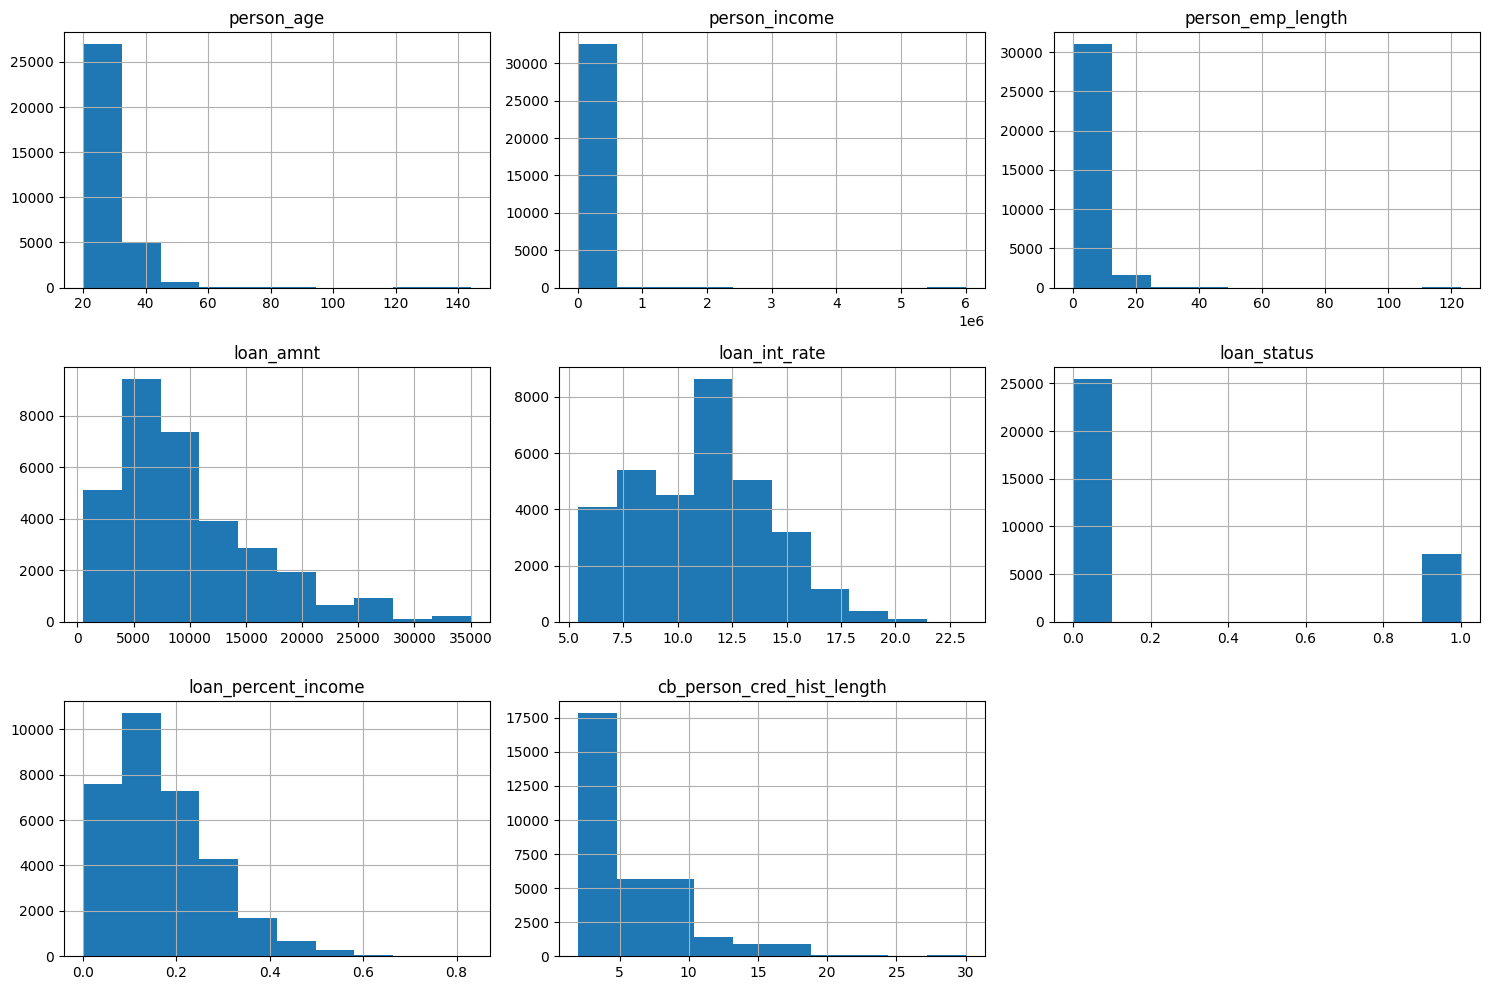

In [7]:
# Se genera un histograma para cada variable numérica
datos_prestamos.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

Se ven valores extremos poco lógicos en las variables de `person_age` y `person_emp_length`; las personas no suelen vivir más de 100 años ni trabajar más de 50. 

Las observaciones afectadas son muy pocas, por lo que se excluyen del conjunto de datos.

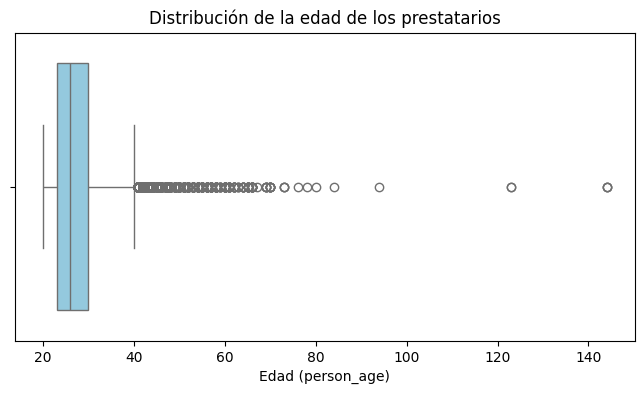

In [8]:
# Gráfico de distribución más detallado incluyendo los cuartiles y los valores extremos
plt.figure(figsize=(8, 4))
sns.boxplot(x=datos_prestamos['person_age'], color='skyblue')
plt.title('Distribución de la edad de los prestatarios')
plt.xlabel('Edad (person_age)')
plt.show()

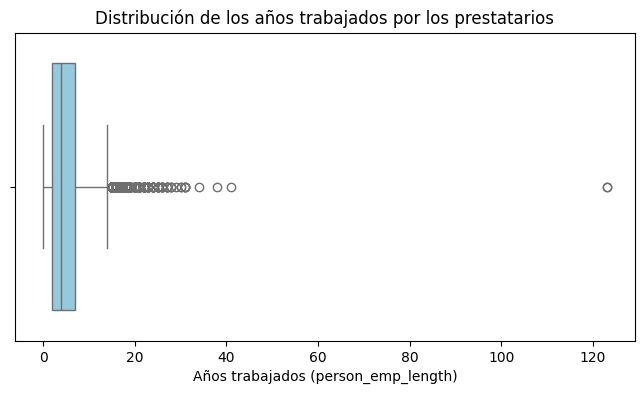

In [9]:
# Gráfico de distribución más detallado incluyendo los cuartiles y los valores extremos
plt.figure(figsize=(8, 4))
sns.boxplot(x=datos_prestamos['person_emp_length'], color='skyblue')
plt.title('Distribución de los años trabajados por los prestatarios')
plt.xlabel('Años trabajados (person_emp_length)')
plt.show()

In [10]:
# Se excluyen los valores atípicos
datos_prestamos = datos_prestamos[datos_prestamos['person_emp_length'] <= 70]
datos_prestamos = datos_prestamos[datos_prestamos['person_age'] <= 110]

La variable `loan_income` tiene una distribución muy claramente sesgada hacia la derecha debido a los valores extremos de millones mientras que la mediana está muy alejada. Sin embargo, los valores extremos son verosímiles; puede ser que una persona cobre ~2.000.000€ netos anuales, y no sería correcto eliminarlos.

Es necesario evitar que los valores extremos no dominen las predicciones del modelo. Para ello, es necesario realizar una transformación logarítmica a la variable, consiguiendo así una distribución normalizada. 

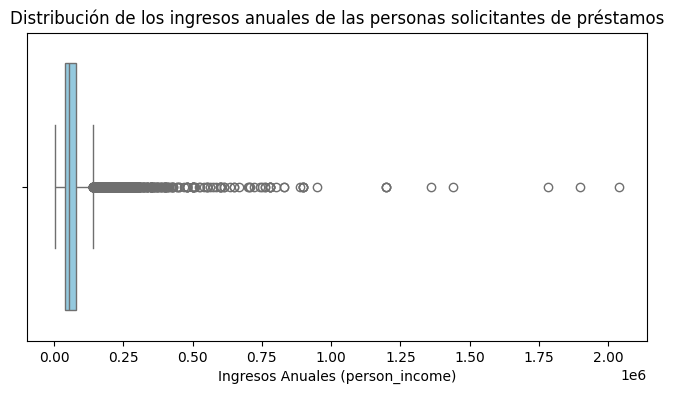

In [11]:
# Gráfico de distribución más detallado incluyendo los cuartiles y los valores extremos
plt.figure(figsize=(8, 4))
sns.boxplot(x=datos_prestamos['person_income'], color='skyblue')
plt.title('Distribución de los ingresos anuales de las personas solicitantes de préstamos')
plt.xlabel('Ingresos Anuales (person_income)')
plt.show()

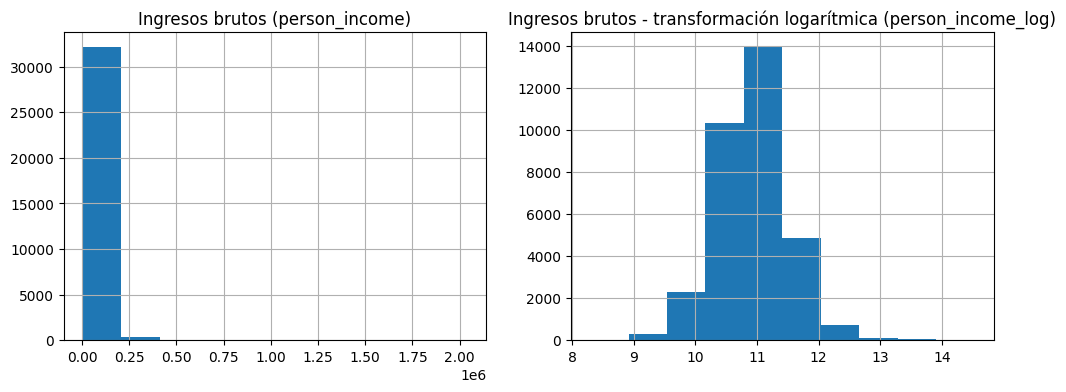

In [12]:
import numpy as np

# Transformacion logarítmica de la variable de ingresos y su almacenamiento en una nueva variable
datos_prestamos['person_income_log'] = np.log1p(datos_prestamos['person_income'])

# Comparación gráfica entre las distribuciones de ambas variables; los ingresos iniciales y los ingresos transformados
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
datos_prestamos['person_income'].hist(ax=ax[0])
ax[0].set_title('Ingresos brutos (person_income)')
datos_prestamos['person_income_log'].hist(ax=ax[1])
ax[1].set_title('Ingresos brutos - transformación logarítmica (person_income_log)')

plt.show()


A la vista de los resultados, se elimina la variable de ingresos original, manteniendo la variable transformada.

In [13]:
# Se elimina la variable de ingresos original
datos_prestamos = datos_prestamos.drop(columns = ['person_income'])

# Se imprimen las variables resultantes
datos_prestamos.columns

Index(['person_age', 'person_home_ownership', 'person_emp_length',
       'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'person_income_log'],
      dtype='object')

En la variable `loan_percent_income` se observan valores interesantes; casos de personas que dedican más de la mitad de sus ingresos a pagar el préstamo. Al estudiar en mayor profundidad estos casos, se identifica que el 78% de ellos generaron impagos. Esta conclusión tiene mucho sentido económico, por lo que esta variable posiblemente sea muy buen indicador de la variable de *default* (`loan_status`).

In [14]:
# Cálculo del porcentaje de préstamos impagados 
# sobre aquellos donde el titular dedica más de la mitad de sus ingresos a pagar el préstamo
default_lpi_bt_50 = datos_prestamos[datos_prestamos['loan_percent_income'] > 0.5]['loan_status'].mean()
print(f'Proporción de impagos cuando el porcentaje de ingresos dedicados al préstamo es mayor al 50%: {default_lpi_bt_50:.2%}')

Proporción de impagos cuando el porcentaje de ingresos dedicados al préstamo es mayor al 50%: 78.54%


## Análisis y corrección de variables categóricas

Variables categóricas:
1. **Tipo de vivienda del solicitante del préstamo**: *home ownership*; si alquila la vivienda en la que vive, si está pagando una hipoteca, si es suya, u otro, por ejemplo, si vive en casa de sus familiares, amigos, etc.
2. **Razón de la solicitud del préstamo**: *loan intent*; a qué se va a destinar el dinero prestado, a pagar un tratamiento médico, estudios académicos, pagar una vivienda (hipoteca), renovar una vivienda, o saldar alguna otra deuda preexistente.

No existe un orden numérico asociado a los valores de estas variables categóricas, por lo que se utiliza la técnica de *One-Hot-Encoding*, es decir, crear una variable por cada valor de "tipo de vivienda" y cada valor de "razón de solicitud del préstamo". En las observaciones donde la persona solicitante esté pagando un alquiler de vivienda y pida un préstamo para realizar unos estudios de máster, todas las variables tomarán valor 0, excepto las que indiquen el que el tipo de vivienda es de `alquiler`, y que el préstamo será destinado a `estudios académicos`, que tomarán valor 1.

In [15]:
# Muestra del número de veces que la variable 'person_home_ownership' toma cada valor único
display(datos_prestamos['person_home_ownership'].value_counts())

person_home_ownership
RENT        16442
MORTGAGE    13441
OWN          2584
OTHER         107
Name: count, dtype: int64

In [16]:
# Creación de una nueva variable para cada valor único de 'person_home_ownership'
# Las nuevas variables toman valor 1 si la variable original contiene el valor que representan, y 0 en caso contrario
# Si 'person_home_ownership' es RENT, home_ownership_rent será 1, mientras que home_ownership_mortgage y las demás serán 0

datos_prestamos['home_ownership_rent'] = (datos_prestamos['person_home_ownership']=='RENT').astype(int)
datos_prestamos['home_ownership_mortgage'] = (datos_prestamos['person_home_ownership']=='MORTGAGE').astype(int)
datos_prestamos['home_ownership_own'] = (datos_prestamos['person_home_ownership']=='OWN').astype(int)
datos_prestamos['home_ownership_other'] = (datos_prestamos['person_home_ownership']=='OTHER').astype(int)

# Muestra de un extracto de los datos para ilustrar el resultado del proceso
display(datos_prestamos[['person_home_ownership', 'home_ownership_rent', 'home_ownership_mortgage', 
                         'home_ownership_own', 'home_ownership_other']].head())

,person_home_ownership,home_ownership_rent,home_ownership_mortgage,home_ownership_own,home_ownership_other
1,OWN,0,0,1,0
2,MORTGAGE,0,1,0,0
3,RENT,1,0,0,0
4,RENT,1,0,0,0
5,OWN,0,0,1,0


In [17]:
# Muestra del número de veces que la variable 'loan_intent' toma cada valor único
display(datos_prestamos['loan_intent'].value_counts())

loan_intent
EDUCATION            6451
MEDICAL              6071
VENTURE              5716
PERSONAL             5519
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

In [18]:
# Creación de una nueva variable para cada valor único de 'loan_intent'
# Las nuevas variables toman valor 1 si la variable original contiene el valor que representan, y 0 en caso contrario
# Si 'loan_intent' es MEDICAL, loan_intent_medical será 1, mientras que loan_intent_education y las demás serán 0

datos_prestamos['loan_intent_education'] = (datos_prestamos['loan_intent']=='EDUCATION').astype(int)  
datos_prestamos['loan_intent_medical'] = (datos_prestamos['loan_intent']=='MEDICAL').astype(int)
datos_prestamos['loan_intent_venture'] = (datos_prestamos['loan_intent']=='VENTURE').astype(int)
datos_prestamos['loan_intent_personal'] = (datos_prestamos['loan_intent']=='PERSONAL').astype(int)
datos_prestamos['loan_intent_debt'] = (datos_prestamos['loan_intent']=='DEBTCONSOLIDATION').astype(int)
datos_prestamos['loan_intent_home'] = (datos_prestamos['loan_intent']=='HOMEIMPROVEMENT').astype(int)

# Muestra de un extracto de los datos para ilustrar el resultado del proceso
display(datos_prestamos[['loan_intent', 'loan_intent_education', 'loan_intent_medical', 
                         'loan_intent_venture', 'loan_intent_personal', 'loan_intent_debt', 'loan_intent_home']].head())

,loan_intent,loan_intent_education,loan_intent_medical,loan_intent_venture,loan_intent_personal,loan_intent_debt,loan_intent_home
1,EDUCATION,1,0,0,0,0,0
2,MEDICAL,0,1,0,0,0,0
3,MEDICAL,0,1,0,0,0,0
4,MEDICAL,0,1,0,0,0,0
5,VENTURE,0,0,1,0,0,0


In [19]:
# Se eliminan las columnas originales categóricas ya codificadas
datos_prestamos = datos_prestamos.drop(columns = ['person_home_ownership', 'loan_intent'])

# Muestra de un extracto de los datos para ilustrar el resultado
display(datos_prestamos.head())

,person_age,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_income_log,home_ownership_rent,home_ownership_mortgage,home_ownership_own,home_ownership_other,loan_intent_education,loan_intent_medical,loan_intent_venture,loan_intent_personal,loan_intent_debt,loan_intent_home
1,21,5.0,B,1000,11.14,0,0.10,N,2,9.169623,0,0,1,0,1,0,0,0,0,0
2,25,1.0,C,5500,12.87,1,0.57,N,3,9.169623,0,1,0,0,0,1,0,0,0,0
3,23,4.0,C,35000,15.23,1,0.53,N,2,11.089821,1,0,0,0,0,1,0,0,0,0
4,24,8.0,C,35000,14.27,1,0.55,Y,4,10.904138,1,0,0,0,0,1,0,0,0,0
5,21,2.0,A,2500,7.14,1,0.25,N,2,9.200391,0,0,1,0,0,0,1,0,0,0



3. **Grado de riesgo del préstamo**: *loan grade*; indica el riesgo asociado a un préstamo, toma valores de la A a la G, correspondiendo A con un riesgo muy bajo y G con el nivel de riesgo más alto.

Esta última variable sí que conlleva un orden implícito, por lo que se puede codificar con valores de 1 a 7, siendo 1 el valor correspondiente con A y 7 el valor asociado a préstamos con calificación G de nivel de riesgo.

In [20]:
# Muestra del número de veces que la variable 'loan_grade' toma cada valor único
display(datos_prestamos['loan_grade'].value_counts())

loan_grade
A    10776
B    10448
C     6456
D     3625
E      964
F      241
G       64
Name: count, dtype: int64

In [21]:
valores =  ['A', 'B', 'C', 'D', 'E', 'F', 'G']
labels = []

# Asignación de un valor numérico (1-7) a cada valor original categórico (A-G) 
# en función del índice del valor original en la lista 'valores'
# Almacenamiento de la nueva asignación en la lista 'labels' para mantener el orden
for i in datos_prestamos['loan_grade']:
    if i in valores:
        labels.append(valores.index(i)+1)

# Asignación de la lista 'labels' con los nuevos valores numéricos correspondientes a la variable original
datos_prestamos['loan_grade'] = labels

# Muestra de los valores únicos en la variable original tras el proceso
print(f"Valores únicos en '{'loan_grade'}': {datos_prestamos['loan_grade'].unique()}")

Valores únicos en 'loan_grade': [2 3 1 4 5 6 7]


4. **Indicador de previas situaciones de impago asociadas a la persona solicitante del préstamo**; *person default on file*, toma valor 'Y' para indicar que sí existieron situaciones de impago en el histórico y 'N' para indicar lo contrario.

En este caso la codificación de esta variable categórica es muy simple, ya que es una variable booleana (Sí o No; Verdadero o Falso; True o False) codificada como categórica. Se sustituye 'Y' (de *yes*) por 1, y 'N' (de *No*) por 0, tranformándola así en una variable numérica.

In [22]:
# Muestra del número de veces que la variable 'cb_person_default_on_file' toma cada valor único
display(datos_prestamos['cb_person_default_on_file'].value_counts())

# Muestra de las cinco primeras observaciones
display(datos_prestamos[['cb_person_default_on_file']].head())

cb_person_default_on_file
N    26830
Y     5744
Name: count, dtype: int64

,cb_person_default_on_file
1,N
2,N
3,N
4,Y
5,N


In [23]:
# Transformación de la variable original; cambiar 'N' por '0' e 'Y' por '1'
datos_prestamos['cb_person_default_on_file'] = datos_prestamos['cb_person_default_on_file'].apply(lambda x: 1 if x=='Y' else 0)

# Muestra de las cinco primeras observaciones tras la transformación (comparar con el resultado del anterior bloque de código)
display(datos_prestamos[['cb_person_default_on_file']].head())

,cb_person_default_on_file
1,0
2,0
3,0
4,1
5,0


# Separación del conjunto de datos

Los datos se dividen entre datos de entrenamiento y datos de validación. Puesto que en este caso no disponemos de marca de tiempo, sencillamente se separa el 80% de los datos para entrenar el modelo, y el 20% se utiliza para validar los resultados obtenidos. 

La opción de `stratify` permite mantener la misma distribución de valores de la variable `loan_status` (target variable) en cada subconjunto de entrenamiento y validación, para que no se acumulen todos o la mayoría de `loan_status`=1 en uno o en otro.

In [24]:
from sklearn.model_selection import train_test_split

# Creación del conjunto X; todas las variables menos la variable objetivo, 'loan_status'
X = datos_prestamos.drop(columns=['loan_status'])

# Creación del conjunto y; la variable objetivo
y = datos_prestamos['loan_status']

# Separación de los conjuntos de entrenamiento (X_entrenamiento, y_entrenamiento) y evaluación (X_eval, y_eval)
# Se estratifica y se reserva el 20% de los datos para la evaluación
# Se utiliza una semilla aleatoria
X_entrenamiento, X_eval, y_entrenamiento, y_eval = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y)

# Optimización de hiperparámetros
Los modelos pueden adaptarse a las necesidades de la tarea mediante hiperparámetros. Con ello se puede ajustar la complejidad computacional del proceso de entrenamiento del modelo, o el nivel de sobreajuste, es decir, la capacidad de aprender y extrapolar los resultados de forma razonable y no memorizada.

Para identificar los hiperparámetros ideales en cada caso, se utiliza una búsqueda exhaustiva; la búsqueda en cuadrícula.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [26]:
from sklearn import linear_model

hpo = {}
# El uso de la misma semilla aleatoria permite obtener el mismo resultado en múltiples ejecuciones 
# sin sacrificar el factor de aleatoriedad
seed = np.random.seed(55)

# Definición de los posibles valores de los hiperaparámetros
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],
    'logistic__penalty': ['l2'],
    'logistic__fit_intercept': [True, False],
    'logistic__solver': ['lbfgs', 'liblinear', 'saga']
}

# Construcción de un pipeline del proceso: 
# 1. se escalan las variables con RobustScaler,
# 2. se aplica el modelo de regresión logística (se establece un número de iteraciones máximas)
log_model= Pipeline([('scaler', RobustScaler()), 
                     ('logistic', linear_model.LogisticRegression(max_iter=10000))])

# Se utiliza la validación cruzada para encontrar los hiperparámetros óptimos
logistic_regr = GridSearchCV(log_model,
                             param_grid,
                             scoring ='f1',
                             n_jobs = 1,
                             verbose = 1)

# Se entrena el modelo de regresión logística con los datos de entrenamiento 
# para cada combinación de hiperparámetros definidas anteriormente en la validación cruzada
logistic_regr.fit(X = X_entrenamiento, y = y_entrenamiento)

# Se almacenan los hiperparámetros con los que se ha obtenido la mejor puntuación durante el entrenamiento 
hpo["LogReg"] = {"best_params": logistic_regr.best_params_, 
                 "best_score": logistic_regr.best_score_}

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [27]:
from sklearn.ensemble import RandomForestClassifier

# Definición de los posibles valores de los hiperaparámetros
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 7, 10, 20],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [2, 3, 4]
}

# Construcción de un pipeline del proceso: 
# 1. se escalan las variables con RobustScaler,
# 2. se aplica el modelo de bosque aleatorio (se establece una semilla de aleatoriedad)
rf_model = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Se utiliza la validación cruzada para encontrar los hiperparámetros óptimos
rf_clf = GridSearchCV(rf_model, param_grid, scoring='f1', n_jobs=-1, verbose=1)

# Se entrena el modelo de bosque aleatorio con los datos de entrenamiento para cada combinación de hiperparámetros
rf_clf.fit(X_entrenamiento, y_entrenamiento)

# Se almacenan los hiperparámetros con los que se ha obtenido la mejor puntuación durante el entrenamiento 
hpo["RandomForest"] = {"best_params": rf_clf.best_params_, "best_score": rf_clf.best_score_}

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [28]:
# Comparación de los resultados de los diferentes modelos, incluyendo la puntuación y los hiperparámetros de cada uno
for model in hpo:
    print(f"Modelo: {model}")
    print(f"  Best Score: {hpo[model]['best_score']}")
    print(f"  Best Params: {hpo[model]['best_params']}")

Modelo: LogReg
  Best Score: 0.6210720010321527
  Best Params: {'logistic__C': 0.01, 'logistic__fit_intercept': False, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'}
Modelo: RandomForest
  Best Score: 0.8253864463446273
  Best Params: {'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


# Construcción de los modelos finales

In [29]:
# ---- Regresión logística ----

# Creación de un pipeline; primero se escalan las variables 
# y después se define el modelo de regresión logística con los hiperparámetros óptimos obtenidos anteriormente
logreg_best = Pipeline([
    ('scaler', RobustScaler()),
    ('logistic', linear_model.LogisticRegression(C=hpo['LogReg']['best_params']['logistic__C'], 
                                                 fit_intercept=hpo['LogReg']['best_params']['logistic__fit_intercept'], 
                                                 penalty=hpo['LogReg']['best_params']['logistic__penalty'], 
                                                 solver=hpo['LogReg']['best_params']['logistic__solver']))
])

# Se entrena el modelo
logreg_best.fit(X_entrenamiento, y_entrenamiento)

# Se utilizan las variables del conjunto de evaluación para predecir la variable objetivo con el modelo entrenado
y_pred_logreg = logreg_best.predict(X_eval)


# ---- Random Forest ----

# Creación de un pipeline; primero se escalan las variables 
# y después se define el modelo de bosque aleatorio con los hiperparámetros óptimos obtenidos anteriormente
rf_best = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(random_state=42, 
                                  max_depth=hpo['RandomForest']['best_params']['rf__max_depth'],
                                  min_samples_leaf=hpo['RandomForest']['best_params']['rf__min_samples_leaf'],
                                  min_samples_split=hpo['RandomForest']['best_params']['rf__min_samples_split'],
                                  n_estimators=hpo['RandomForest']['best_params']['rf__n_estimators'],))
])

# Se entrena el modelo
rf_best.fit(X_entrenamiento, y_entrenamiento)

# Se utilizan las variables del conjunto de evaluación para predecir la variable objetivo con el modelo entrenado
y_pred_rf = rf_best.predict(X_eval)

# Evaluación de los modelos

Este proceso consiste en comparar los resultados reales almacenados en `y_eval` con los resultados de la predicción de cada modelo, almacenados en `y_pred_logreg` e `y_pred_rf`.

Se evalúan con la métrica ROC-AUC, que indica su capacidad discriminatoria general. Adicionalmente, se comparan los falsos y verdaderos positivos y negativos predecidos con cada modelo mediante la matriz de confusión.

In [30]:
import sklearn.metrics as metrics

# ---- Regresión logística ----

# Cálculo de las métricas de evaluación: precisión, sensibilidad, F1 y ROC_AUC
logreg_precision = metrics.precision_score(y_eval, y_pred_logreg)
logreg_sensibilidad = metrics.recall_score(y_eval, y_pred_logreg) 
logreg_f1 = metrics.f1_score(y_eval, y_pred_logreg)
logreg_roc_auc = metrics.roc_auc_score(y_eval, y_pred_logreg)

print("\nPrecisión Logistic Regression:", logreg_precision,
      "\nSensibilidad Logistic Regression:", logreg_sensibilidad,
      "\nF1 Logistic Regression:", logreg_f1,
      "\nROC-AUC Logistic Regression:", logreg_roc_auc)

# ---- Random Forest ----

# Cálculo de las métricas de evaluación: precisión, sensibilidad, F1 y ROC_AUC
rf_precision = metrics.precision_score(y_eval, y_pred_rf)
rf_sensibilidad = metrics.recall_score(y_eval, y_pred_rf)
rf_f1 = metrics.f1_score(y_eval, y_pred_rf)
rf_roc_auc = metrics.roc_auc_score(y_eval, y_pred_rf)

print("/nPrecisión Random Forest:", rf_precision,
      "/nSensibilidad Random Forest:", rf_sensibilidad,
      "/nF1 Random Forest:", rf_f1,
      "/nROC-AUC Random Forest:", rf_roc_auc)


Precisión Logistic Regression: 0.7433628318584071 
Sensibilidad Logistic Regression: 0.5320197044334976 
F1 Logistic Regression: 0.6201804757998359 
ROC-AUC Logistic Regression: 0.7403914776584449
/nPrecisión Random Forest: 0.9831516352824579 /nSensibilidad Random Forest: 0.6980999296270233 /nF1 Random Forest: 0.8164609053497942 /nROC-AUC Random Forest: 0.8473813350530092


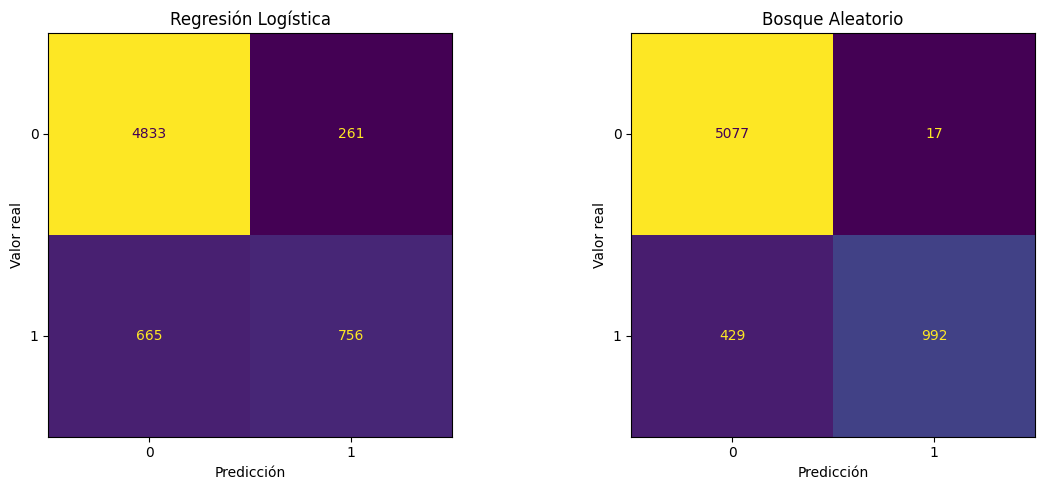

In [31]:
# Matriz de confusión - Regresión Logística
cm_logreg = metrics.confusion_matrix(y_eval, y_pred_logreg)
disp_logreg = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_logreg)

# Matriz de confusión - Bosque Aleatorio
cm_rf = metrics.confusion_matrix(y_eval, y_pred_rf)
disp_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_rf)

# Gráfico comparativo de ambas matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
disp_logreg.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Regresión Logística")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Valor real")

disp_rf.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Bosque Aleatorio")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Valor real")

plt.tight_layout()
plt.show()